In [1]:
import pandas as pd
import numpy as np
from shapely import wkt
import geopandas as gpd

# Zoning Data

In [2]:
multifamily = {'R-M', 'R-M(PD)', 'R-M(CL)', 'R-2', 'R-2(PD)', 'UV', 'CP', 
               'CP(PD)', 'MUC', 'MUN', 'DC', 'DC-NT1', 'DC(PD)'}
#confirm what R-M(CL) means
#make sure we don't need to include others

In [3]:
sj_zips = gpd.read_file('Zip_Code_Boundary.geojson')
sj_zips['geometry'] = sj_zips['geometry'].apply(wkt.loads)
#sj_zips = sj_zips.to_crs(epsg = 26910) #converting crs to planar

sj_zones = gpd.read_file('zoning_data/Zoning_2022.geojson')
sj_zones['geometry'] = sj_zones['geometry'].apply(wkt.loads)

#sj_zones = sj_zones.to_crs(epsg = 26910) #converting crs to planar


TypeError: Expected bytes or string, got MultiPolygon

In [40]:
sj_zones['area'] = sj_zones.area #creating area column

In [42]:
def calculate_percentage(group):
    total_area = group['area'].sum()
    rm_area = group[group['ZONINGABBREV'].isin(multifamily)]['area'].sum()
    percentage = rm_area / total_area
    return percentage

In [43]:
def calc_area(group):
    return group['area'].sum()

**Final Year**

In [44]:
joined_data = gpd.sjoin(sj_zips, sj_zones, how='inner', predicate='intersects')


percentages = (
    joined_data.groupby('ZIPCODE').apply(calculate_percentage)
    .reset_index(name='multifam_percentage')
)

areas = (
    joined_data.groupby('ZIPCODE').apply(calc_area)
    .reset_index(name='total_area')
)

joined_data = joined_data.merge(percentages, on = 'ZIPCODE', how = 'left')
joined_data = joined_data.merge(areas, on = 'ZIPCODE', how = 'left')


abbrev_data = joined_data[['ZIPCODE', 'FACILITYID', 'ZONINGABBREV', 'multifam_percentage', 'total_area']]
abbrev_data['ZIPCODE'] = abbrev_data['ZIPCODE'].astype('int64')

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_7872/2472129552.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbrev_data['ZIPCODE'] = abbrev_data['ZIPCODE'].astype('int64')


**Base Year (2012)**

In [47]:
base_zones = gpd.read_file('zoning_data/Zoning_2012.geojson')
base_zones = base_zones.to_crs(sj_zones.crs)

base_zones['area'] = base_zones.area #creating area column


base_joined = gpd.sjoin(sj_zips, base_zones, how='inner', predicate='intersects')

base_percentages = (
    base_joined.groupby('ZIPCODE').apply(calculate_percentage)
    .reset_index(name='multifam_percentage_2012')
)


base_joined = base_joined.merge(base_percentages, on = 'ZIPCODE', how = 'left')


abbrev_base = base_joined[['ZIPCODE', 'FACILITYID', 'ZONINGABBREV', 'multifam_percentage_2012']]
abbrev_base['ZIPCODE'] = abbrev_base['ZIPCODE'].astype('int64')

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_7872/507162131.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbrev_base['ZIPCODE'] = abbrev_base['ZIPCODE'].astype('int64')


**Intermediate Year (2015)**

In [48]:
zones_15 = gpd.read_file('zoning_data/Zoning_2015.geojson')

zones_15 = zones_15.to_crs(sj_zones.crs)
zones_15['area'] = zones_15.area #creating area column


joined_15 = gpd.sjoin(sj_zips, zones_15, how='inner', predicate='intersects')

percentages_15 = (
    joined_15.groupby('ZIPCODE').apply(calculate_percentage)
    .reset_index(name='multifam_percentage_2015')
)



joined_15 = joined_15.merge(percentages_15, on = 'ZIPCODE', how = 'left')


abbrev_15 = joined_15[['ZIPCODE', 'FACILITYID', 'ZONINGABBREV', 'multifam_percentage_2015']] 
abbrev_15['ZIPCODE'] = abbrev_15['ZIPCODE'].astype('int64')

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_7872/1853754223.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbrev_15['ZIPCODE'] = abbrev_15['ZIPCODE'].astype('int64')


**Joining**

In [49]:
to_join_base = abbrev_base[['ZIPCODE', 'multifam_percentage_2012']].groupby('ZIPCODE').max()
to_join_15 = abbrev_15[['ZIPCODE', 'multifam_percentage_2015']].groupby('ZIPCODE').max()
to_join_final = abbrev_data[['ZIPCODE', 'multifam_percentage', 'total_area']].groupby('ZIPCODE').max()

temp = to_join_base.merge(to_join_15, how = 'inner', left_index = True, right_index = True)
zip_panel = temp.merge(to_join_final, how = 'inner', left_index = True, right_index = True)

In [50]:
#creating independent variables
zip_panel['initial_diff'] = zip_panel['multifam_percentage_2015'] - zip_panel['multifam_percentage_2012']
zip_panel['final_diff'] = zip_panel['multifam_percentage'] - zip_panel['multifam_percentage_2015']

# Rent Data

In [51]:
#final year rents
rents = pd.read_excel('fy2021_safmrs_revised.xlsx')

rents.rename({
    'ZIP\nCode': 'ZIP Code', 
    'SAFMR\n0BR': 'SAFMR 0BR',
    'SAFMR\n0BR - 90%\nPayment\nStandard': 'SAFMR 0BR - 90% Payment Standard',
    'SAFMR\n0BR - 110%\nPayment\nStandard': 'SAFMR 0BR - 110% Payment Standard',
    'SAFMR\n1BR': 'SAFMR 1BR',
       'SAFMR\n1BR - 90%\nPayment\nStandard': 'SAFMR 1BR - 90% Payment Standard',
       'SAFMR\n1BR - 110%\nPayment\nStandard': 'SAFMR 1BR - 110% Payment Standard', 
    'SAFMR\n2BR': 'SAFMR 2BR',
       'SAFMR\n2BR - 90%\nPayment\nStandard': 'SAFMR 2BR - 90% Payment Standard',
       'SAFMR\n2BR - 110%\nPayment\nStandard': 'SAFMR 2BR - 110% Payment Standard', 
    'SAFMR\n3BR': 'SAFMR 3BR',
       'SAFMR\n3BR - 90%\nPayment\nStandard': 'SAFMR 3BR - 90% Payment Standard',
       'SAFMR\n3BR - 110%\nPayment\nStandard': 'SAFMR 3BR - 110% Payment Standard', 
    'SAFMR\n4BR': 'SAFMR 4BR',
       'SAFMR\n4BR - 90%\nPayment\nStandard': 'SAFMR 4BR - 90% Payment Standard',
       'SAFMR\n4BR - 110%\nPayment\nStandard': 'SAFMR 4BR - 110% Payment Standard'
}, axis = 1, inplace = True)

abbrev_rents = rents[['ZIP Code', 'SAFMR 0BR', 'SAFMR 1BR',
                     'SAFMR 2BR', 'SAFMR 3BR', 'SAFMR 4BR']]
del rents

In [52]:
#base year rents
rents_2012 = pd.read_excel('small_area_fmrs_fy2012.xls')

rents_2012 = rents_2012[rents_2012['County Name'] == 'Santa Clara County']
rents_2012 = rents_2012[['ZIP', 'area_rent_br0', 'area_rent_br1', 'area_rent_br2', 'area_rent_br3', 'area_rent_br4']]

rents_2012.rename({
    'area_rent_br0': '0BR_base', 'area_rent_br1': '1BR_base', 
    'area_rent_br2': '2BR_base', 'area_rent_br3': '3BR_base', 
    'area_rent_br4': '4BR_base'
}, axis = 1, inplace = True)

rents_2012['ZIP'] = rents_2012['ZIP'].astype('int64')

In [53]:
#adjusting for inflation
rents_2012['0BR_base'] = rents_2012['0BR_base'] * 1.1802
rents_2012['1BR_base'] = rents_2012['1BR_base'] * 1.1802
rents_2012['2BR_base'] = rents_2012['2BR_base'] * 1.1802
rents_2012['3BR_base'] = rents_2012['3BR_base'] * 1.1802
rents_2012['4BR_base'] = rents_2012['4BR_base'] * 1.1802

**Calculating change in rent**

In [54]:
merged_rents = rents_2012.merge(abbrev_rents, left_on = 'ZIP', right_on = 'ZIP Code')

## 'SAFMR xBR' is the convention used in 2021, compared to xBR_base being used in 2012
merged_rents['0BR_change'] = merged_rents['SAFMR 0BR'] - merged_rents['0BR_base']
merged_rents['1BR_change'] = merged_rents['SAFMR 1BR'] - merged_rents['1BR_base']
merged_rents['2BR_change'] = merged_rents['SAFMR 2BR'] - merged_rents['2BR_base']
merged_rents['3BR_change'] = merged_rents['SAFMR 3BR'] - merged_rents['4BR_base']
merged_rents['4BR_change'] = merged_rents['SAFMR 4BR'] - merged_rents['4BR_base']

changes = merged_rents[['ZIP', '0BR_change', '1BR_change', 
                        '2BR_change', '3BR_change', '4BR_change',
                       '0BR_base', '1BR_base', '2BR_base', '3BR_base', '4BR_base']]

# Demographic Data (controls)

In [55]:
test_demo = pd.read_csv('controls_data/full_2012_demographics.csv')

test_demo['Label (Grouping)'] = test_demo['Label (Grouping)'].apply(lambda x: str(x).replace(u'\xa0', u''))
test_demo.columns = test_demo.columns.str.replace('!!', ' ')


test_demo['Label (Grouping)'] = test_demo['Label (Grouping)'].apply(lambda x: str(x).replace(u'\xa0', u''))
test_demo.columns = test_demo.columns.str.replace('!!', ' ')


og = test_demo.copy()

#to get the rows outside of "one race" dropdown
rows = [2] + list(range(60, 70))
test_demo = test_demo.iloc[rows]


#note that median age and total housing units are in 'estimate' columns
vals_to_keep = {'Male', 'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Islander',
                'Some Other Race', 'Hispanic or Latino (of any race)',
               }

test_demo = test_demo[test_demo['Label (Grouping)'].isin(vals_to_keep)]


test_demo = test_demo.filter(regex='^(?=.*(?i)percent|label)(?!.*(?i)percent margin of error)')

pivoted = test_demo.set_index('Label (Grouping)').T
pivoted.reset_index(inplace = True)
pivoted.rename({'index': 'ZIP'}, axis = 1, inplace = True)
pivoted['ZIP'] = pivoted['ZIP'].str.extract(r'ZCTA5 (\d+) Percent')[0]

In [56]:
# Getting the non-percent values
og = og.filter(regex='^(?=.*(?i)estimate|label)(?!.*(?i)estimate margin of error)')

og = og.set_index('Label (Grouping)')
og_pivot = og[(og.index == 'Total housing units') | (og.index == 'Median age (years)') | 
              (og.index == 'Total population')].T

og_pivot = og_pivot.T.drop_duplicates(keep = 'first').T

og_pivot.reset_index(inplace = True)
og_pivot.rename({'index': 'ZIP'}, axis = 1, inplace = True)
og_pivot['ZIP'] = og_pivot['ZIP'].str.extract(r'ZCTA5 (\d+) Estimate')[0]

no_income = pivoted.merge(og_pivot, on = 'ZIP')

In [57]:
#2012 income data

raw_med_12 = pd.read_csv('controls_data/sj_med_income_2012.csv')
raw_med_12.columns = raw_med_12.columns.str.replace('!!', ' ')

mean_med = raw_med_12[(raw_med_12['Label (Grouping)'] == 'Median income (dollars)') 
           | (raw_med_12['Label (Grouping)'] == 'Mean income (dollars)')]

mean_med = mean_med.filter(regex=r'^(ZCTA5 \d{5} Households Estimate|Label \(Grouping\))$')


pivoted_income = mean_med.set_index('Label (Grouping)').T


pivoted_income.reset_index(inplace = True)
pivoted_income.rename({'index': 'ZIP'}, axis = 1, inplace = True)
pivoted_income['ZIP'] = pivoted_income['ZIP'].str.extract(r'ZCTA5 (\d+) Households Estimate')[0]
pivoted_income.replace({'-': np.nan}, inplace = True)

pivoted_income['Median income (dollars)'] = (
    pivoted_income['Median income (dollars)'].str.replace(',', '').astype('float64')
)

pivoted_income['Mean income (dollars)'] = (
    pivoted_income['Mean income (dollars)'].str.replace(',', '').astype('float64')
)

full_controls = no_income.merge(pivoted_income, on = 'ZIP')

In [58]:
#cleaning

full_controls.replace('-', np.nan, inplace = True)

def clean_pct(column):
    return column.str.rstrip('%').astype(float) / 100

def clean_totals(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    else:
        return val

to_clean = ['Male', 'White', 'Black or African American', 'American Indian and Alaska Native',
           'Asian', 'Native Hawaiian and Other Pacific Islander', 'Hispanic or Latino (of any race)']

full_controls[to_clean] = full_controls[to_clean].apply(clean_pct)

full_controls['Total population'] = full_controls['Total population'].apply(clean_totals)
full_controls['Total housing units'] = full_controls['Total housing units'].apply(clean_totals)

full_controls['Density per unit'] = full_controls['Total population'] / full_controls['Total housing units']

full_controls['ZIP'] = full_controls['ZIP'].astype('int64')


# Creating Final Panel

In [59]:
#merge zoning df with rent df
temp_full = zip_panel.merge(changes, left_index = True, right_on = 'ZIP').set_index('ZIP')

In [60]:
#merge zoning+rent df with demographic controls
final_panel = (
    temp_full.merge(full_controls, 
                    left_index = True, right_on = 'ZIP')
    .set_index('ZIP')
)

In [61]:
final_panel.columns

Index(['multifam_percentage_2012', 'multifam_percentage_2015',
       'multifam_percentage', 'total_area', 'initial_diff', 'final_diff',
       '0BR_change', '1BR_change', '2BR_change', '3BR_change', '4BR_change',
       '0BR_base', '1BR_base', '2BR_base', '3BR_base', '4BR_base', 'Male',
       'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander',
       'Hispanic or Latino (of any race)', 'Total population',
       'Median age (years)', 'Total housing units', 'Median income (dollars)',
       'Mean income (dollars)', 'Density per unit'],
      dtype='object')

In [62]:
2255 * 1.609

3628.295

In [63]:
final_panel['total_area'] / 10**6

ZIP
94089    33.770267
95002    34.981492
95008     2.185294
95013    10.618704
95014     0.234710
95032     2.295076
95035     4.932860
95035     4.932860
95037    65.753632
95050     4.415411
95054     0.533089
95070     0.664657
95110    10.494093
95111    12.182760
95112    17.472942
95113     1.090133
95116     7.962061
95117     5.210083
95118     9.578386
95119     5.651687
95120    32.374134
95121    11.188166
95122    11.593521
95123    17.802432
95124    12.640850
95125    16.863776
95126     7.135985
95127    12.227588
95128     6.666200
95129     9.250160
95130     3.474657
95131    14.552169
95132    18.064787
95133     7.382770
95134    49.671234
95135    29.057895
95136    11.802690
95138    51.497116
95139     2.415724
95140     0.553321
95148    11.363167
Name: total_area, dtype: float64

In [64]:
final_panel['Population density (per km)'] = (
    final_panel['Total population'] / (final_panel['total_area'] / 10**6)
)

<Axes: >

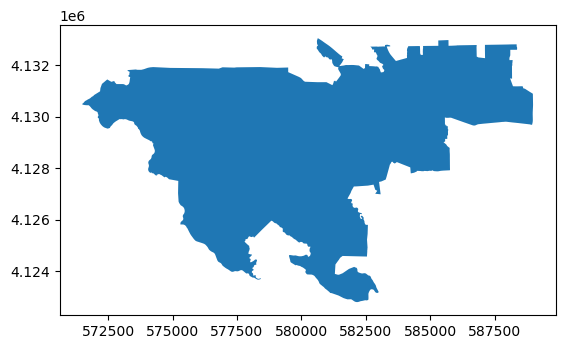

In [65]:
sj_zips[sj_zips['ZIPCODE'] == '95014']['geometry'].plot()

In [67]:
final_panel.to_csv('full_data.csv')

In [68]:
final_panel.columns

Index(['multifam_percentage_2012', 'multifam_percentage_2015',
       'multifam_percentage', 'total_area', 'initial_diff', 'final_diff',
       '0BR_change', '1BR_change', '2BR_change', '3BR_change', '4BR_change',
       '0BR_base', '1BR_base', '2BR_base', '3BR_base', '4BR_base', 'Male',
       'White', 'Black or African American',
       'American Indian and Alaska Native', 'Asian',
       'Native Hawaiian and Other Pacific Islander',
       'Hispanic or Latino (of any race)', 'Total population',
       'Median age (years)', 'Total housing units', 'Median income (dollars)',
       'Mean income (dollars)', 'Density per unit',
       'Population density (per km)'],
      dtype='object')

# EDA

In [69]:
final_panel.corr()

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_7872/3196270021.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_panel.corr()


,multifam_percentage_2012,multifam_percentage_2015,multifam_percentage,total_area,initial_diff,final_diff,0BR_change,1BR_change,2BR_change,3BR_change,...,American Indian and Alaska Native,Asian,Native Hawaiian and Other Pacific Islander,Hispanic or Latino (of any race),Total population,Total housing units,Median income (dollars),Mean income (dollars),Density per unit,Population density (per km)
multifam_percentage_2012,1.000000,0.999418,0.791911,-0.227971,0.058290,-0.027858,0.258067,0.330858,0.303480,0.431313,...,0.318131,-0.132734,-0.286782,0.065344,-0.146396,-0.092890,-0.599779,-0.490979,-0.537390,-0.068866
multifam_percentage_2015,0.999418,1.000000,0.793807,-0.240336,0.092317,-0.025517,0.250361,0.323690,0.296121,0.425395,...,0.316294,-0.134161,-0.285939,0.066514,-0.142902,-0.091387,-0.599878,-0.490329,-0.529603,-0.066834
multifam_percentage,0.791911,0.793807,1.000000,-0.347418,0.115118,0.587717,0.283829,0.338052,0.317469,0.409037,...,0.155248,-0.035349,-0.249520,0.003880,0.063255,0.145625,-0.470239,-0.365485,-0.454689,0.455168
total_area,-0.227971,-0.240336,-0.347418,1.000000,-0.378958,-0.251339,0.021836,-0.000564,0.015212,-0.039763,...,-0.061316,-0.018446,-0.019487,0.072809,-0.061463,-0.065841,0.142392,0.197877,0.059707,-0.234397
initial_diff,0.058290,0.092317,0.115118,-0.378958,1.000000,0.066412,-0.206027,-0.184821,-0.192450,-0.140685,...,-0.028550,-0.052021,0.002046,0.039247,0.091204,0.036984,-0.050008,-0.019624,0.184818,0.054276
final_diff,-0.027858,-0.025517,0.587717,-0.251339,0.066412,1.000000,0.133479,0.125056,0.127898,0.106435,...,-0.165759,0.120233,-0.028836,-0.081943,0.294080,0.360944,0.026637,0.052674,-0.041198,0.837089
0BR_change,0.258067,0.250361,0.283829,0.021836,-0.206027,0.133479,1.000000,0.991279,0.993985,0.938682,...,-0.269554,0.263920,-0.403357,-0.506226,-0.278356,-0.205075,0.261298,0.359256,-0.488986,0.245569
1BR_change,0.330858,0.323690,0.338052,-0.000564,-0.184821,0.125056,0.991279,1.000000,0.998974,0.975646,...,-0.223910,0.201417,-0.445909,-0.445570,-0.285116,-0.210496,0.187292,0.288893,-0.508939,0.212880
2BR_change,0.303480,0.296121,0.317469,0.015212,-0.192450,0.127898,0.993985,0.998974,1.000000,0.968513,...,-0.242621,0.218154,-0.443286,-0.454597,-0.284500,-0.215047,0.217349,0.314092,-0.488868,0.224948
3BR_change,0.431313,0.425395,0.409037,-0.039763,-0.140685,0.106435,0.938682,0.975646,0.968513,1.000000,...,-0.138741,0.088551,-0.497038,-0.319866,-0.282749,-0.211757,0.057050,0.159780,-0.511824,0.149763
